<a href="https://colab.research.google.com/github/19rehan/ML-techniques-end-to-end/blob/main/Mobile_price_Classifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

In [43]:
df = pd.read_csv("/content/Mobilephone_data_final.csv")

df.sample(10)

,Sr. No.,Name,Brand,Model,Battery capacity (mAh),Screen size (inches),Touchscreen,Resolution x,Resolution y,Processor,RAM (MB),Internal storage (GB),Rear camera,Front camera,Operating system,Wi-Fi,Bluetooth,GPS,Number of SIMs,3G,4G/ LTE,Price
753,753,Sony Xperia XZ2,Sony,Xperia XZ2,3180,5.7,Yes,1080,2160,8,4000,64.000,19.0,5.0,Android,Yes,Yes,Yes,2,Yes,Yes,57900
553,553,Lenovo Vibe X2,Lenovo,Vibe X2,2300,5.0,Yes,1080,1920,8,2000,32.000,13.0,5.0,Android,Yes,Yes,Yes,2,Yes,Yes,17499
818,818,Lava Z80,Lava,Z80,2500,5.0,Yes,720,1280,4,3000,16.000,8.0,5.0,Android,Yes,Yes,Yes,2,Yes,Yes,4725
1221,1221,Intex Cloud 3G Candy,Intex,Cloud 3G Candy,1400,4.0,Yes,480,800,1,256,0.512,2.0,0.3,Android,Yes,Yes,Yes,2,Yes,No,1999
1307,1307,HTC Desire 728 Dual SIM,HTC,Desire 728 Dual SIM,2800,5.5,Yes,720,1280,8,2000,16.000,13.0,5.0,Android,Yes,Yes,Yes,2,No,Yes,5999
987,987,Micromax Vdeo 1,Micromax,Vdeo 1,1600,4.0,Yes,480,800,4,1000,8.000,5.0,2.0,Android,Yes,Yes,Yes,2,Yes,Yes,4499
280,280,Meizu M16th,Meizu,M16th,3010,6.0,Yes,1080,2160,8,8000,128.000,12.0,20.0,Android,Yes,Yes,Yes,2,Yes,Yes,19990
1172,1172,Intex Aqua Twist,Intex,Aqua Twist,2200,5.0,Yes,480,854,4,1000,8.000,5.0,0.0,Android,Yes,Yes,Yes,2,Yes,No,3499
325,325,Redmi 5A,Xiaomi,Redmi 5A,3000,5.0,Yes,720,1280,4,2000,16.000,13.0,5.0,Android,Yes,Yes,Yes,2,Yes,Yes,7199
542,542,Asus ZenFone C (ZC451CG),Asus,ZenFone C (ZC451CG),2100,4.5,Yes,480,854,2,1000,8.000,5.0,0.3,Android,Yes,Yes,No,2,Yes,No,5499


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sr. No.                 1359 non-null   int64  
 1   Name                    1359 non-null   object 
 2   Brand                   1359 non-null   object 
 3   Model                   1359 non-null   object 
 4   Battery capacity (mAh)  1359 non-null   int64  
 5   Screen size (inches)    1359 non-null   float64
 6   Touchscreen             1359 non-null   object 
 7   Resolution x            1359 non-null   int64  
 8   Resolution y            1359 non-null   int64  
 9   Processor               1359 non-null   int64  
 10  RAM (MB)                1359 non-null   int64  
 11  Internal storage (GB)   1359 non-null   float64
 12  Rear camera             1359 non-null   float64
 13  Front camera            1359 non-null   float64
 14  Operating system        1359 non-null   

In [45]:
df.isnull().sum()

,0
Sr. No.,0
Name,0
Brand,0
Model,0
Battery capacity (mAh),0
Screen size (inches),0
Touchscreen,0
Resolution x,0
Resolution y,0
Processor,0


In [46]:
# Check relationship between price_range and 0-megapixel front camera
zero_fc_by_price = df[df['Front camera'] == 0].groupby('Price')['Price'].count()
print("Phones with 0MP Front Camera by Price Range:")
print(zero_fc_by_price)


Phones with 0MP Front Camera by Price Range:
Price
1999     1
2999     1
3190     1
3499     3
3850     1
3999     1
4888     1
4990     1
4999     2
6999     1
7500     2
7999     1
9990     1
35990    1
Name: Price, dtype: int64


In [47]:
df = df[df['Front camera'] != 0]

/tmp/ipython-input-3248903139.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Price', data=df, palette='viridis')


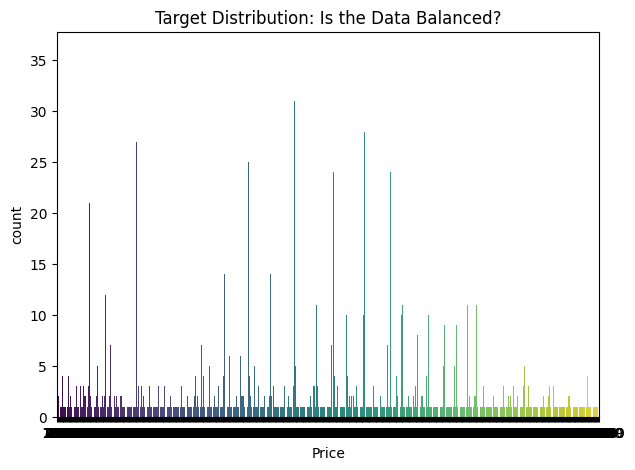

Price
4999     36
6999     31
8999     28
3999     27
5999     25
         ..
2490      1
11586     1
6490      1
4090      1
6390      1
Name: count, Length: 624, dtype: int64


In [48]:
# Checking if each price range (0, 1, 2, 3) has equal samples
plt.figure(figsize=(7,5))
sns.countplot(x='Price', data=df, palette='viridis')
plt.title("Target Distribution: Is the Data Balanced?")
plt.show()

print(df['Price'].value_counts())

In [49]:
X = df.drop('Price', axis=1)
y = df['Price']

In [50]:
# Check which columns have non-numeric data
print("--- Column Data Types ---")
print(X.dtypes)

# Find exactly where '10.or G' is hiding
mask = X.apply(lambda x: x.map(lambda y: '10.or G' in str(y))).any(axis=1)
print("\nRows containing the string:")
print(X[mask])

--- Column Data Types ---
Sr. No.                     int64
Name                       object
Brand                      object
Model                      object
Battery capacity (mAh)      int64
Screen size (inches)      float64
Touchscreen                object
Resolution x                int64
Resolution y                int64
Processor                   int64
RAM (MB)                    int64
Internal storage (GB)     float64
Rear camera               float64
Front camera              float64
Operating system           object
Wi-Fi                      object
Bluetooth                  object
GPS                        object
Number of SIMs              int64
3G                         object
4G/ LTE                    object
dtype: object

Rows containing the string:
     Sr. No.      Name  Brand Model  ...  GPS  Number of SIMs   3G  4G/ LTE
659      659  10.or G2  10.or    G2  ...  Yes               2  Yes      Yes
824      824   10.or G  10.or     G  ...  Yes               2  Ye

In [52]:
# 1. Drop columns that are too unique to help the model generalize
X = df.drop(['Sr. No.', 'Name', 'Model', 'Price'], axis=1)

# 2. Convert Binary 'Yes/No' objects to 0/1
binary_cols = ['Touchscreen', 'Wi-Fi', 'Bluetooth', 'GPS', '3G', '4G/ LTE']
for col in binary_cols:
    X[col] = X[col].map({'Yes': 1, 'No': 0})

# 3. One-Hot Encode the remaining objects (Brand, OS)
X_final = pd.get_dummies(X, columns=['Brand', 'Operating system'], drop_first=True)

# 4. Now perform the Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# 5. Standard Scaler on the final numeric matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data ready! New feature count: {X_final.shape[1]}")

Data ready! New feature count: 97


In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize Models
models = {
    "KNN (Proximity Logic)": KNeighborsClassifier(n_neighbors=5),
    "SVM (Boundary Logic)": SVC(kernel='linear', C=1.0),
    "Decision Tree (Rule Logic)": DecisionTreeClassifier(random_state=42)
}

# Training Loop
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

KNN (Proximity Logic) Accuracy: 0.0112
SVM (Boundary Logic) Accuracy: 0.0037
Decision Tree (Rule Logic) Accuracy: 0.0074
